In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### Create custom metric (calculates $\sqrt[4]{\sum_i( \hat y_i - y_i)^4}$). This metric can be used just like any other built-in metric during training

In [76]:
class FourthRootFourthPowerError(tf.keras.metrics.Metric):

  def __init__(self, name = 'frfpe', **kwargs):
    # Define the state variables
    super().__init__(name = name, **kwargs)
    self.frfpe_sum = self.add_weight(name = 'frfpe_sum', initializer = 'zeros') # Stores current value of metric
    self.total_samples = self.add_weight(name = 'total_samples', dtype = 'int32', initializer = 'zeros') # Stores number of samples

  def update_state(self, y_true, y_pred, sample_weight = None):
    frfpe = tf.reduce_sum(tf.square(tf.square(y_true - y_pred)))
    self.frfpe_sum.assign_add(frfpe)
    num_of_samples = y_true.shape[0]
    self.total_samples.assign_add(num_of_samples)

  def reset_state(self):
    # Needed to use in training across different epochs without need to reinstantiate metric object
    self.frfpe_sum.assign(0.)
    self.total_samples.assign(0)

  def result(self):
    # Return current value of metric according to above formula
    return tf.sqrt(tf.sqrt((self.frfpe_sum / tf.cast(self.total_samples, dtype = 'float32'))))

### Create custom callback

In [ ]:
class CrazyCallback(tf.keras.callbacks.Callback):
  '''
  below, logs is a dictionary containing information about the previous batch, epoch, or training, valida-
tion metrics, and so on.
  '''
  def on_train_begin(logs):
    import time
    self.start_time = time.time()
    self.per_batch_losses = []

  def on_train_end(logs):
    self.end_time = time.time()
    print(f'Training took {self.end_time - self.start_time} seconds')

  def on_epoch_begin(epoch, logs):
    print(f'Starting {epoch} epoch')

  def on_epoch_end(epoch, logs):
    # Plots per_batch_loss after each epoch of training
    plt.clf()
    plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses) # plot per_batch_losses after epoch of training
    plt.ylabel('Loss')
    plt.xlabel(f'Batch (epoch {epoch})')
    plt.title('Training loss for each batch')
    plt.show()
    self.per_batch_losses = [] # reset per_batch_losses after epoch of training

  def on_batch_begin(batch, logs):
    pass

  def on_batch_end(batch, logs):
    self.per_batch_losses.append(logs.get('loss'))




### Create custom training loop

Let's write custom training loop, that is going to try to copy a given image

In [2]:
!wget https://petla-zulaw.pl/files/gallery/zulawy-1-73ab6d.jpg

--2023-09-26 08:28:11--  https://petla-zulaw.pl/files/gallery/zulawy-1-73ab6d.jpg
Resolving petla-zulaw.pl (petla-zulaw.pl)... 46.242.233.177
Connecting to petla-zulaw.pl (petla-zulaw.pl)|46.242.233.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283939 (277K) [image/jpeg]
Saving to: ‘zulawy-1-73ab6d.jpg’

zulawy-1-73ab6d.jpg 100%[===================>] 277.28K   725KB/s    in 0.4s    

2023-09-26 08:28:12 (725 KB/s) - ‘zulawy-1-73ab6d.jpg’ saved [283939/283939]



In [5]:
# Load photo
photo = plt.imread('zulawy-1-73ab6d.jpg')
print(photo.shape)

(750, 1000, 3)


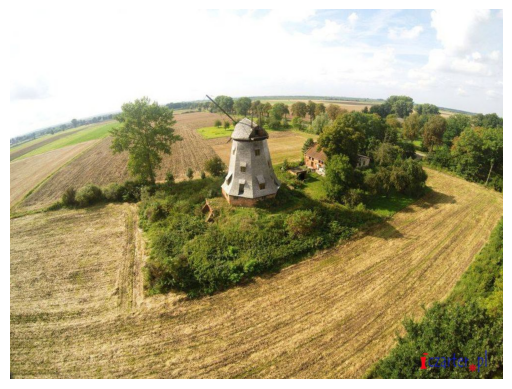

In [54]:
# Display photo
plt.imshow(photo)
plt.axis('off')
plt.show()

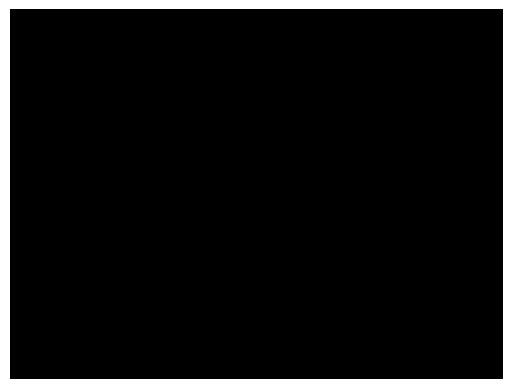

In [78]:
# Create blank tensor of the shape of the photo that is going to be copied
blank_photo = np.zeros(shape = photo.shape)

# Picture of copied photo
plt.imshow(blank_photo)
plt.axis('off')
plt.show()

# Scale down original photo
photo_rescaled = photo/255.

# Turning both photos into tensors
photo_rescaled = tf.constant(photo_rescaled, dtype = 'float32')
blank_photo = tf.Variable(blank_photo, dtype = 'float32')

In [79]:
# Define parameters
learning_rate = 0.1
metric = FourthRootFourthPowerError() # Trying out custom metric

# Define train step
def train_step(inputs, targets):
  '''
  inputs - photo to be copied
  targets - copied photo
  '''
  with tf.GradientTape() as tape:
    loss = (inputs - targets)**2
    print(tf.reduce_sum(loss).numpy())

  gradients = tape.gradient(loss, targets)
  targets.assign_sub(learning_rate * gradients)

# Define train loop
epochs = 5

for epoch in range(epochs):
  # Reset value of metric
  metric.reset_state()
  # Perform one step of train_step
  train_step(photo_rescaled, blank_photo)
  # Calculate value of a metric after one training step
  metric.update_state(photo_rescaled, blank_photo)
  # Display metric value
  print(f"Custom metric value at epoch {epoch}: {metric.result()}")


984129.75
Custom metric value at epoch 0: 4.468323707580566
629842.9
Custom metric value at epoch 1: 3.5746593475341797
403099.44
Custom metric value at epoch 2: 2.859727144241333
257983.69
Custom metric value at epoch 3: 2.2877814769744873
165109.61
Custom metric value at epoch 4: 1.8302253484725952


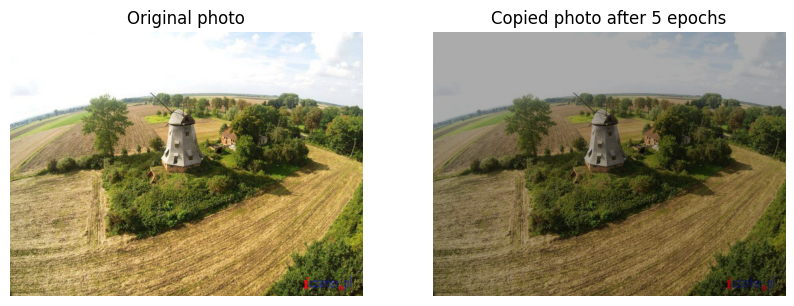

In [80]:
# Picture of copied photo
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(w = 10, h = 10)
ax[0].imshow(photo_rescaled.numpy())
ax[0].set_title('Original photo')
ax[1].imshow(blank_photo.numpy())
ax[1].set_title('Copied photo after 5 epochs')
ax[0].axis('off')
ax[1].axis('off')
plt.show()